Nenwin-project (NEural Networks WIthout Neurons) for
the AI Honors Academy track 2020-2021 at the TU Eindhoven.

Authors: Teun Schilperoort, Lulof Pirée

April 2021

Copyright (C) 2021 Lulof Pirée, Teun Schilperoort

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

# MNIST with Nenwin

In [1]:
import torch
import torch.nn
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Iterable
from numbers import Number

from nenwin.constants import MNIST_CHECKPOINT_DIR
from nenwin.all_particles import MarbleEaterNode, Marble, Node, MarbleEmitterNode
from nenwin.model import NenwinModel
from nenwin.input_placer import InputPlacer, PhiInputPlacer
from nenwin.attraction_functions.attraction_functions import ThresholdGravity, AttractionFunction
from nenwin.backprop.filename_gen import FilenameGenerator
from nenwin.backprop.trainer import NenwinTrainer
from nenwin.backprop.training_stats import TrainingStats
from nenwin.backprop.loss_function import NenwinLossFunction
from nenwin.mnist.load_dataset import load_mnist_dataset, MNISTDataset

In [2]:
DATASET = load_mnist_dataset()
print(DATASET)

MNISTDataset
	train samples: 50000
	vali samples: 10000
	test samples: 10000
	input type: <class 'torch.Tensor'>
	label type: <class 'int'>


## First architecture: symmetric

The following architecture is used to testrun the training algorithm
on real data. It is designed as follows:
* There is a square, in which Nodes are placed in a grid. 
* There are no nodes in a smaller square area in the middle of the larger square: this is the input region.
* MarbleEaterNodes used as outputs are placed in a circle around the rectangle. They are equally divided over the circumference of the circle (i.e. the length of the arch between two neighbouring MarbleEaterNodes is equal for all pairs). The radius and position of the circle is such that it intersects the vertices of the large square.
* There are 10 MarbleEaterNodes, since the MNIST dataset has 10 different classes.

Sketch (circle not shown):
```
 ^  100+-------------+
 |     |   nodes     |
 y     |   +----+    |
       |   |    |    |
       |   +----+    |
       |             |
      0+-------------+
       0             100 -> x
```



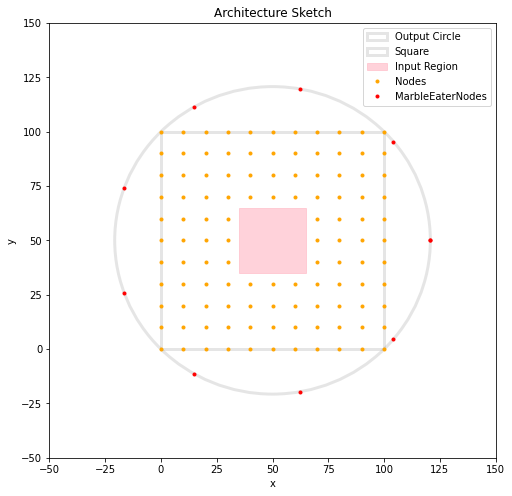

In [3]:
SQUARE_SIZE = (100, 100)
SQUARE_LOWER_LEFT_POS = (0, 0)
INPUT_REGION_SIZE = (30, 30)
INPUT_REGION_LOWER_LEFT_POS = (35, 35)
INPUT_CENTER = np.add(INPUT_REGION_LOWER_LEFT_POS, np.multiply(0.5, INPUT_REGION_SIZE))
CIRCLE_RADIUS = 100 / np.sqrt(2)
CIRCLE_CENTER = (50, 50)
# Horizontal / vertical distance between nodes. 
# For a NODE_SPACING of 10, 11 nodes will fit in a row of length 100.
NODE_SPACING = 10 
NUM_OUTPUT_NODES = 10

MASS = 1
EATER_RADIUS = 1
GRAVITY_RADIUS = 100

LOSS_POS_WEIGHT = 1
LOSS_VEL_WEIGHT = 1


def plot_shapes():
    """
    Generate a simple plot of the square, circle and input region as defined above.
    As a visual check if the numerical descriptions are correct.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    circle = plt.Circle(CIRCLE_CENTER, CIRCLE_RADIUS, facecolor='none',
                edgecolor="gray", linewidth=3, alpha=0.2)
    ax.add_patch(circle)
    square = plt.Rectangle(SQUARE_LOWER_LEFT_POS, *SQUARE_SIZE, facecolor='none',
                edgecolor="gray", linewidth=3, alpha=0.2)
    ax.add_patch(square)
    input_region = plt.Rectangle(INPUT_REGION_LOWER_LEFT_POS, *INPUT_REGION_SIZE, facecolor='pink',
                edgecolor="pink", linewidth=1, alpha=0.7)
    ax.add_patch(input_region)

    node_positions = np.array(gen_node_positions())
    nodes = ax.plot(node_positions[:, 0], node_positions[:, 1], ".", color="orange", label="Nodes")

    output_eater_positions = np.array(gen_output_eater_positions())
    eaters = ax.plot(output_eater_positions[:, 0], output_eater_positions[:, 1], 
        ".", color="red", label="MarbleEaterNodes")

    # print(help(ax.legend))
    ax.legend()
    ax.legend((circle, square, input_region, nodes[0], eaters[0]), 
              ("Output Circle", "Square", "Input Region", "Nodes", "MarbleEaterNodes"))

    ax.set_xlim((-50, 150))
    ax.set_ylim((-50, 150))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Architecture Sketch")
    plt.show()

def gen_node_positions(spacing = NODE_SPACING) -> List[Tuple[int, int]]:
    """
    Compute the locations of the Nodes in the square.
    Do not place any Node in the input region 
    or on the boundary of the input region.
    """
    positions = []
    for x in range(0, SQUARE_SIZE[0] + spacing, spacing):
        for y in range(0, SQUARE_SIZE[1] + spacing, spacing):
            if not pos_in_input_region(x, y):
                positions.append((x, y))
    return positions

def pos_in_input_region(x: Number, y: Number) -> bool:
    """
    Return True if the point (x, y) is in the input region.
    Return False otherwise, 
    also in case (x, y) is on the boundary of the input region.
    """
    x_in = abs(x - INPUT_CENTER[0]) < INPUT_REGION_SIZE[0]/2
    y_in = abs(y - INPUT_CENTER[1]) < INPUT_REGION_SIZE[1]/2
    return x_in and y_in

def gen_output_eater_positions() -> List[Tuple[float, float]]:
    positions = []
    angles = np.linspace(0, 2*np.pi, num=NUM_OUTPUT_NODES, endpoint = True)
    for angle in angles:
        x = CIRCLE_CENTER[0] + CIRCLE_RADIUS * np.cos(angle)
        y = CIRCLE_CENTER[1] + CIRCLE_RADIUS * np.sin(angle)
        positions.append((x, y))
    return positions
plot_shapes()

In [4]:
def gen_model() -> Tuple[NenwinModel, List[MarbleEaterNode]]:
    gravity_radius = GRAVITY_RADIUS
    attract_funct = ThresholdGravity(gravity_radius)
    zero = torch.tensor([0.0, 0.0])

    nodes = gen_nodes(zero, attract_funct)
    eater_nodes = gen_eater_nodes(zero, attract_funct)
    return NenwinModel(nodes+eater_nodes), eater_nodes

def create_trainer(model: NenwinModel,
                   input_placer: InputPlacer,
                   output_nodes: Iterable[MarbleEaterNode],
                   dataset: MNISTDataset,
                   loss_pos_weight: float,
                   loss_vel_weight: float) -> NenwinTrainer:

    loss_funct = NenwinLossFunction(output_nodes, model, loss_vel_weight,
                                    loss_pos_weight)
    optim = torch.optim.Adam(model.parameters())
    filename_gen = FilenameGenerator(MNIST_CHECKPOINT_DIR, "MNIST_", ".txt")
    trainer = NenwinTrainer(model, loss_funct, optim, filename_gen,
                            input_placer, dataset)
    return trainer

def gen_nodes(zero: torch.Tensor, 
              attract_funct: AttractionFunction,
              mass: float = MASS) -> List[Node]:
    nodes = []
    for node_pos in gen_node_positions():
        node_pos = torch.tensor(node_pos, dtype=torch.float)
        node = Node(pos=node_pos, vel=zero, acc=zero, 
                    mass=mass,
                    attraction_function=attract_funct, 
                    marble_stiffness = 1,
                    node_stiffness = 1,
                    marble_attraction = 1,
                    node_attraction = 0)
        nodes.append(node)
    return nodes

def gen_eater_nodes(zero: torch.Tensor,
                    attract_funct: AttractionFunction,
                    mass: float = MASS,
                    radius: float = EATER_RADIUS) -> List[MarbleEaterNode]:
    eaters = []
    for eater_pos in gen_output_eater_positions():
        eater_pos = torch.tensor(eater_pos, dtype=torch.float)
        eater = MarbleEaterNode(pos=eater_pos, vel=zero, acc=zero, 
                    mass=mass,
                    attraction_function=attract_funct, 
                    marble_stiffness = 1,
                    node_stiffness = 1,
                    marble_attraction = 1,
                    node_attraction = 0,
                    radius = radius)
        eaters.append(eater)
    return eaters


MODEL, EATERS = gen_model()
INPUT_PLACER = PhiInputPlacer(INPUT_REGION_LOWER_LEFT_POS, INPUT_REGION_SIZE)
TRAINER = create_trainer(MODEL, 
                         INPUT_PLACER, 
                         EATERS,
                         DATASET,
                         loss_pos_weight= LOSS_POS_WEIGHT,
                         loss_vel_weight = LOSS_VEL_WEIGHT)


### Running the actual trainer

In [5]:
num_epochs = 10
step_size = 0.01
num_steps_till_read_output = 1 / step_size
do_validate = True
checkpoint_interval = 100

TRAINER.run_training(num_epochs,
                     step_size,
                     num_steps_till_read_output,
                     do_validate,
                     checkpoint_interval)

torch.Size([28, 28])


IndexError: list index out of range

Help on method plot in module matplotlib.axes._axes:

plot(*args, scalex=True, scaley=True, data=None, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the ap

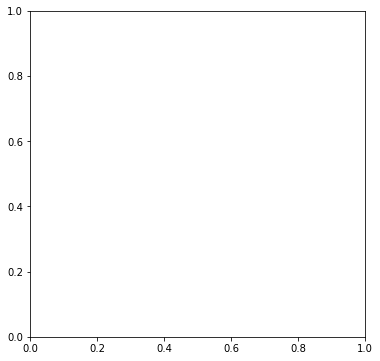

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
help(ax.plot)